In [1]:
import sys
sys.path += [".."]

import smbh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def newDensity(r, a = 1e-3, alpha = 0, beta = 2.2):
    return 1 / ((r / a) ** alpha * (1 + r / a) ** (beta - alpha))

def oldDensity(r, a = 1e-3, n = -2.2):
    try:
        if(r < a): return 1
        else: return (a / r) ** -n
    except ValueError:
        d = r.copy()
        d[r < a] = 1
        d[r >= a] = (a / r[r >= a]) ** -n
        return d

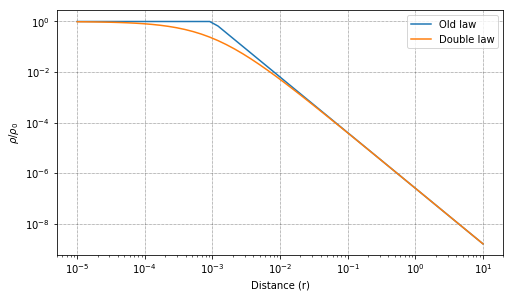

In [3]:
r = np.logspace(-5, 1)

rho_o = oldDensity(r)
rho_n = newDensity(r)

fig, ax = plt.subplots(figsize = (8, 4.5))

ax.plot(r, rho_o, label = 'Old law')
ax.plot(r, rho_n, label = 'Double law')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$\rho/\rho_0$')
ax.set_xlabel('Distance (r)')

ax.legend()

ax.grid()

In [4]:
import sympy as spy
spy.init_printing()

In [5]:
def gradient(Phi):
    global a_1, a_2, a_3, x, y, z, m, m_int, phi_x, phi_y, phi_z, phi_1, phi_2, phi_3
    phi = Phi.subs(m, m_int)
    dim = [x, y, z]
    phis = [phi_x, phi_y, phi_z]
    phis_ = [phi_1, phi_2, phi_3]
    
    r = []
    for (x_i, phi_x_i, phi_i) in zip(dim, phis, phis_):
        t = phi.diff(x_i).subs(m_int / a_1, m / a_1).subs(m_int ** 2, m ** 2).simplify()
        t = (t / phi_x_i).factor()
        r.append(t)
        
    if r[0] == r[1]:
        factor = r[0]
        matrix = spy.Matrix(phis_)
    else: 
        factor = 1
        matrix = spy.Matrix(r)
    return factor, matrix


In [6]:
G, tau, omega, gamma = spy.symbols(r'G \tau \omega \gamma', real = True, positive = True)
m, x, y, z, a_1, a_2, a_3, phi_1, phi_2, phi_3 = spy.symbols("m x y z a_1 a_2 a_3 \phi_1 \phi_2 \phi_3",
                                                                real = True, positive = True)

m_int = [i ** 2 / (a ** 2 + tau) for (i, a) in zip([x, y, z], [a_1, a_2, a_3])]
m_int = spy.sqrt(a_1 ** 2 * sum(m_int))

phi_x = x / (spy.sqrt(tau + a_1 ** 2) ** 3 * spy.sqrt(tau + a_2 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_y = y / (spy.sqrt(tau + a_2 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_z = z / (spy.sqrt(tau + a_3 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_2 ** 2))

# New density

In [7]:
r_0, rho_0, m, n, G = spy.symbols(r'r_0 rho_0 m n G', positive = True, real = True)

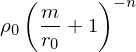

In [8]:
rho = rho_0 * (1 + m / r_0)**-n
rho

## mass

In [9]:
u = spy.symbols('u', positive = True, real = True)

mass = 4 * spy.pi * m ** 2 * rho
mass = mass.subs(m, u * r_0)
integral = mass.integrate(u)
integral = (integral - integral.subs(u, 0)).subs(u, m / r_0).simplify()

In [10]:
subs = [(rho_0, 1), (r_0, 1e-3)]
newMass = spy.lambdify([m, n], integral.subs(subs))

<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide


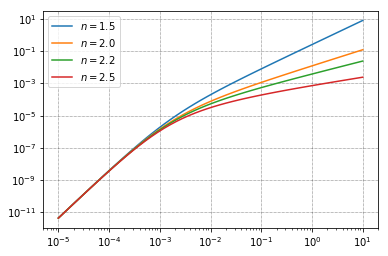

In [11]:
for i in [1.5, 2., 2.2, 2.5]:
    masses = newMass(r, i)
    plt.plot(r, masses, label = '$n = %.1f$'%i)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

# Potential

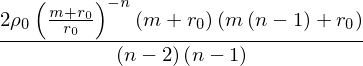

\frac{2 \rho_{0} \left(\frac{m + r_{0}}{r_{0}}\right)^{- n} \left(m + r_{0}\right) \left(m \left(n - 1\right) + r_{0}\right)}{\left(n - 2\right) \left(n - 1\right)}


In [12]:
psi = (2 * rho_0 * (r_0 + m) * ((r_0 + m) / r_0) ** -n * (r_0 + (n - 1) * m)) / ((n - 2) * (n - 1))
display(psi)
print(spy.latex(psi))

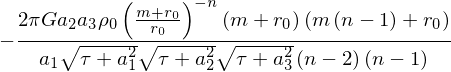

In [13]:
phi = - spy.pi * G * (a_2 * a_3 / a_1) * psi / spy.sqrt((tau + a_1 ** 2) * (tau + a_2 ** 2) * (tau + a_3 ** 2))
phi

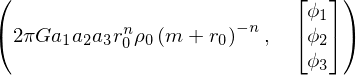

In [14]:
factor, vector = gradient(phi)
factor, vector

In [15]:
print(spy.latex(factor))

2 \pi G a_{1} a_{2} a_{3} r_{0}^{n} \rho_{0} \left(m + r_{0}\right)^{- n}
